<a href="https://colab.research.google.com/github/kae1dy/NLPCodeReview/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install datasets
!pip install transformers
!pip install umap-learn
!pip install 'umap-learn[plot]'

from datasets import Dataset
import pandas as pd
from transformers import AutoModel, AutoTokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=f729c28b493788f95e6cb245

In [5]:
# preprocessing dataset

url = "https://raw.githubusercontent.com/CommentFinder/CommentFinder/master/dataset"

data_files = {
    "train": url + "/train.tsv",
    "test":  url + "/test.tsv",
}
train = pd.read_csv(data_files["train"], header=None, sep='\t', on_bad_lines='skip', skipinitialspace=True, names=['source', 'target'])
test = pd.read_csv(data_files["test"], header=None, sep='\t', on_bad_lines='skip', skipinitialspace=True, names=['source', 'target'])

train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test[:5000])

train, test

(Dataset({
     features: ['source', 'target'],
     num_rows: 134225
 }),
 Dataset({
     features: ['source', 'target'],
     num_rows: 5000
 }))

In [6]:
checkpoint = "Salesforce/codet5p-110m-embedding"
device = "cuda"

import gc
gc.collect()

tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)
model = AutoModel.from_pretrained(checkpoint, trust_remote_code=True).to(device)

# code embedding
def get_embedding(source):
    input = tokenizer(source, padding=True, truncation=True, return_tensors="pt") # truncation=True
    input = {k: v.to(device) for k, v in input.items()}

    model_output = model(**input)
    return model_output

train = train.map(
    # lambda batch: get_embedding(batch["source"]), batched=True, batch_size=16
    lambda batch: {"embedding": get_embedding(batch["source"]).detach().cpu().numpy()[0]}, remove_columns=["source"]
)
test = test.map(
    lambda batch: {"embedding": get_embedding(batch["source"]).detach().cpu().numpy()[0]}, remove_columns=["source"]
)

# with batched ~35 examples/s
# without ~50 examples/s
# verdict: batched < none-batched (why???)

# detach ... выпилить
# понять есть ли для test'a n примеров построить 10 и определить похож не похож

train.save_to_disk('./train')
test.save_to_disk('./test')

train, test

# проверить батчи, **input - не факт, что работает как кажется, draw_umap(...)

Map:   0%|          | 0/134225 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/134225 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

(Dataset({
     features: ['target', 'embedding'],
     num_rows: 134225
 }),
 Dataset({
     features: ['target', 'embedding'],
     num_rows: 5000
 }))

In [7]:
from datasets import load_from_disk

train = load_from_disk('./train')
test = load_from_disk('./test')

In [9]:
import time
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from functools import wraps

import numpy as np


# train['embedding'], test['embedding']
print(f'\nVector Length: {len(test["embedding"][0])}.')

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        total_time = time.perf_counter() - start_time
        print(f'\nTime cost ({func.__name__}): {total_time:.4f} seconds.')
        return result
    return timeit_wrapper


@timeit
def predict_top_k(test, source, topk=10) -> list:
    prediction = []
    similarity = cosine_similarity(test['embedding'], source['embedding'])

    for index, similar in enumerate(tqdm(similarity)):

        index_nn = np.argpartition(similar, -topk)[-topk:]
        current_prediction = [source['target'][i] for i in index_nn[::-1]]

        prediction += current_prediction

    # write the recommendation comments to the file named as "predictions_k.txt"
    with open('predictions_' + str(topk) + '.txt', 'a') as f:
        for data in prediction:
            f.write(data + '\n')
    return prediction


def batch_data(data, batch_size=1024):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

# Compute the cosine distance and its computational time
prediction = []

for test_batch in batch_data(test):
    prediction += predict_top_k(test_batch, train)


Vector Length: 256.


100%|██████████| 1024/1024 [23:19<00:00,  1.37s/it]



Time cost (predict_top_k): 1426.5843 seconds.


100%|██████████| 1024/1024 [23:31<00:00,  1.38s/it]



Time cost (predict_top_k): 1433.4624 seconds.


100%|██████████| 1024/1024 [23:25<00:00,  1.37s/it]



Time cost (predict_top_k): 1428.8154 seconds.


100%|██████████| 1024/1024 [23:50<00:00,  1.40s/it]



Time cost (predict_top_k): 1453.7139 seconds.


100%|██████████| 904/904 [21:07<00:00,  1.40s/it]


Time cost (predict_top_k): 1291.1057 seconds.


In [10]:
import numpy as np
from nltk.translate import bleu_score
from tqdm import tqdm
import statistics

# bleu неправильно считается

# Evaluate perfect prediction & BLEU score of our approach
prediction = [line.strip() for line in open("./predictions_10.txt")]
chencherry = bleu_score.SmoothingFunction()

print(len(prediction))

BLEU_score = { 1:  [],
               3:  [],
               5:  [],
               10: []
}
count_perfect = { 1:  0,
                  3:  0,
                  5:  0,
                  10: 0
}

for i, target in enumerate(tqdm(test['target'])):
    best_BLEU = 0
    flag_perfect = 0
    for counter, pred in enumerate(prediction[10 * i: 10 * i + 10], 1):
        current_BLEU = bleu_score.sentence_bleu([pred.split()], target.split(), smoothing_function=chencherry.method1)
        best_BLEU = max(best_BLEU, current_BLEU)

        if " ".join(pred.split()) == " ".join(target.split()):
            flag_perfect = 1

        if counter in BLEU_score.keys():
            BLEU_score[counter].append(best_BLEU)
            count_perfect[counter] += flag_perfect


for k in BLEU_score.keys():
    print(f'\nPP    : %d/%d (%s%.2f)' % (count_perfect[k], len(test['target']), '%', (count_perfect[k] * 100) / len(test['target'])))
    print(f'BLEU mean              : ', statistics.mean(BLEU_score[k]))


50000


100%|██████████| 5000/5000 [00:08<00:00, 608.27it/s]


PP    : 73/5000 (%1.46)
BLEU mean              :  0.019353448280319478

PP    : 132/5000 (%2.64)
BLEU mean              :  0.035784493046543304

PP    : 177/5000 (%3.54)
BLEU mean              :  0.046968018669151505

PP    : 204/5000 (%4.08)
BLEU mean              :  0.056764908995633176


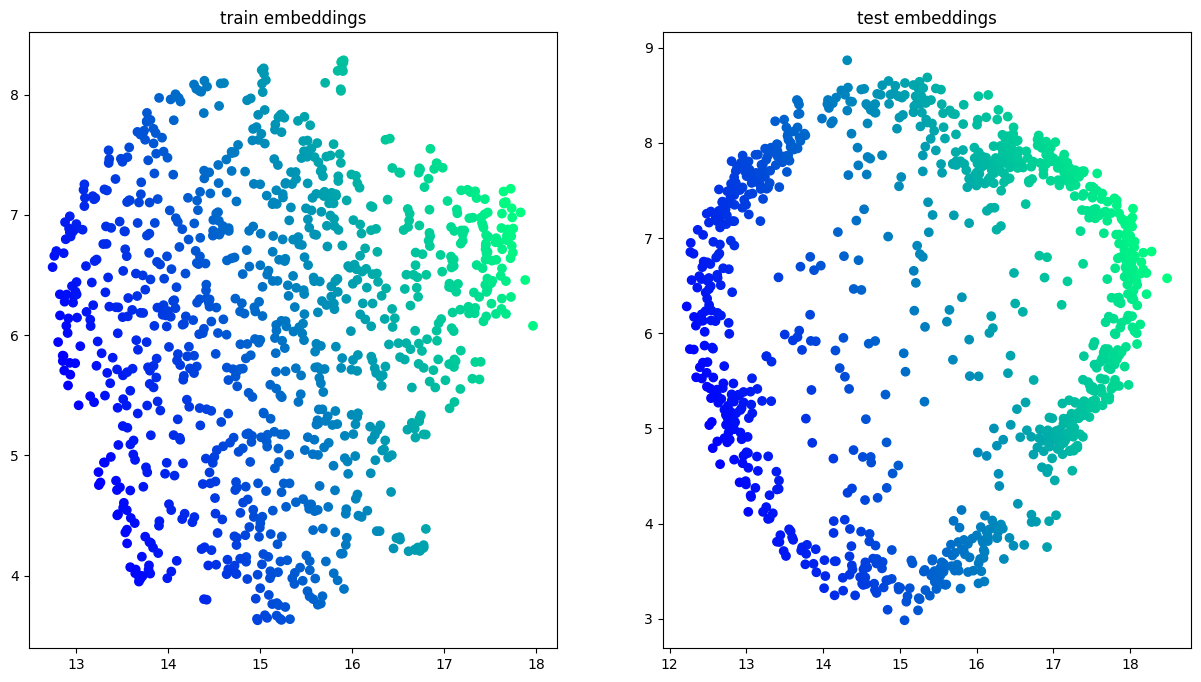

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import umap.umap_ as umap
import umap.plot
from datasets import load_from_disk

%matplotlib inline

train = load_from_disk('./train')
test = load_from_disk('./test')
# train, test

num_vector = 1000

def draw_UMAP(data, n_neighbors=10, min_dist=0.2, metric='cosine', n_components=2):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(f'n_neighbors={n_neighbors} min_dist={min_dist}, metric={metric}', fontsize=14)

# ---------- 3D-picture ----------
# 3d best:
# 10 0.1 cosine
# 15 0.0 cosine
# 15 0.99 correlation
# 25 0.0 cosine

# fit = umap.UMAP(
#         n_neighbors=25,
#         min_dist=0.0,
#         metric='cosine',
#         n_components=3
# )
# umap_train = fit.fit_transform(train.shuffle(seed=42)["embedding"][:num_vector])
# umap_test = fit.transform(test.shuffle(seed=42)["embedding"][:num_vector])


# fig = plt.figure(figsize=(12, 12))
# axs = [fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')]

# axs[0].set_title('train embeddings')
# axs[1].set_title('test embeddings')

# axs[0].scatter(umap_train[:,0], umap_train[:,1], umap_train[:,2],
#               c=np.sqrt(umap_train[:,0] ** 2 + umap_train[:,1] ** 2 + umap_train[:,2] ** 2),
#               cmap='winter'
# )
# axs[1].scatter(umap_test[:,0], umap_test[:,1], umap_test[:,2],
#               c=np.sqrt(umap_test[:,0] ** 2 + umap_test[:,1] ** 2 + umap_test[:,2] ** 2),
#               cmap='winter'
# )
# plt.savefig('./graph_apart_3d.png')

# ----------2D-picture-------------
# 2d best:
# 5 0.0 euclidean
# 10 0.0 manh
# 25 0.25 cosine

fit = umap.UMAP(
    n_neighbors=25,
    min_dist=0.0,
    metric='cosine',
)
umap_train = fit.fit_transform(train.shuffle(seed=42)["embedding"][:num_vector])
umap_test = fit.transform(test.shuffle(seed=42)["embedding"][:num_vector])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axs[0].set_title('train embeddings')
axs[1].set_title('test embeddings')

axs[0].scatter(umap_train[:,0], umap_train[:,1], c=np.sqrt(umap_train[:,0] ** 2 + umap_train[:,1] ** 2), cmap='winter')
axs[1].scatter(umap_test[:,0], umap_test[:,1], c=np.sqrt(umap_test[:,0] ** 2 + umap_test[:,1] ** 2), cmap='winter')

plt.savefig('./graph_apart_2d.png')


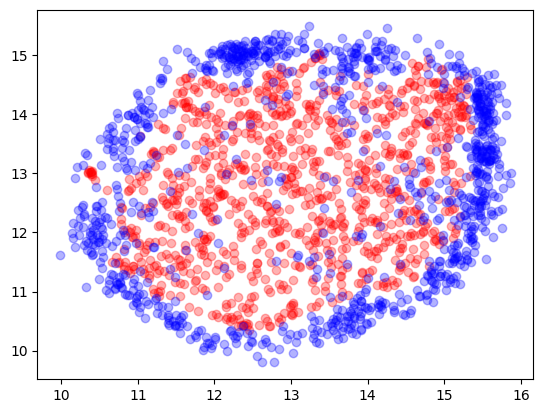

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import umap.umap_ as umap
import umap.plot
from datasets import load_from_disk

%matplotlib inline

train = load_from_disk('./train')
test = load_from_disk('./test')
# train, test

num_vector = 1000

fit = umap.UMAP(
    n_neighbors=25,
    min_dist=0.0,
    metric='cosine',
)
umap_train = fit.fit_transform(train.shuffle(seed=42)["embedding"][:num_vector])
umap_test = fit.transform(test.shuffle(seed=42)["embedding"][:num_vector])

plt.scatter(umap_train[:,0], umap_train[:,1], c='red', alpha=0.3)
plt.scatter(umap_test[:,0], umap_test[:,1], c='blue', alpha=0.3)

plt.savefig('./graph_togeth.png')